In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 131.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [15]:
def download_pose_model():
    import urllib.request
    model_url = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task"
    model_path = "pose_landmarker_heavy.task"

    if not os.path.exists(model_path):
        print("Downloading pose landmarker model...")
        urllib.request.urlretrieve(model_url, model_path)
        print("Model downloaded successfully!")

    return model_path

In [16]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import random
import warnings
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
def create_val_split(dataset_dir='/content/drive/MyDrive/archive/DATASET'):
    print("CREATING VALIDATION SPLIT")

    train_dir = os.path.join(dataset_dir, 'TRAIN')
    test_dir = os.path.join(dataset_dir, 'TEST')
    val_dir = os.path.join(dataset_dir, 'VAL')

    if not os.path.exists(train_dir):
        print(f"{train_dir}/ not found!")
        return False

    poses = [d for d in os.listdir(train_dir)
             if os.path.isdir(os.path.join(train_dir, d))]

    print(f"\nFound {len(poses)} poses: {poses}\n")

    for pose in poses:
        os.makedirs(os.path.join(val_dir, pose), exist_ok=True)

    for pose in poses:
        train_pose_dir = os.path.join(train_dir, pose)
        val_pose_dir = os.path.join(val_dir, pose)

        images = [f for f in os.listdir(train_pose_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        random.seed(42)
        random.shuffle(images)

        n_val = int(len(images) * 0.15)
        val_imgs = images[:n_val]

        print(f"{pose}:")
        print(f"  Moving {n_val} images from TRAIN to VAL")

        for img in val_imgs:
            src = os.path.join(train_pose_dir, img)
            dst = os.path.join(val_pose_dir, img)
            shutil.move(src, dst)

    print("VALIDATION SPLIT CREATED!")
    print(f"\nDataset structure:")
    print(f"  {dataset_dir}/TRAIN/")
    print(f"  {dataset_dir}/VAL/")
    print(f"  {dataset_dir}/TEST/\n")

    return True

In [18]:
def extract_pose_features(image, pose_landmarker):
    image_np = np.array(image)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_np)
    detection_result = pose_landmarker.detect(mp_image)

    if detection_result.pose_landmarks and len(detection_result.pose_landmarks) > 0:
        landmarks = detection_result.pose_landmarks[0]

        LEFT_SHOULDER, RIGHT_SHOULDER = 11, 12
        LEFT_ELBOW, RIGHT_ELBOW = 13, 14
        LEFT_HIP, RIGHT_HIP = 23, 24
        LEFT_KNEE, RIGHT_KNEE = 25, 26

        ls = (landmarks[LEFT_SHOULDER].x, landmarks[LEFT_SHOULDER].y)
        rs = (landmarks[RIGHT_SHOULDER].x, landmarks[RIGHT_SHOULDER].y)
        le = (landmarks[LEFT_ELBOW].x, landmarks[LEFT_ELBOW].y)
        re = (landmarks[RIGHT_ELBOW].x, landmarks[RIGHT_ELBOW].y)
        lh = (landmarks[LEFT_HIP].x, landmarks[LEFT_HIP].y)
        rh = (landmarks[RIGHT_HIP].x, landmarks[RIGHT_HIP].y)
        lk = (landmarks[LEFT_KNEE].x, landmarks[LEFT_KNEE].y)
        rk = (landmarks[RIGHT_KNEE].x, landmarks[RIGHT_KNEE].y)

        features = [
            np.arctan2(le[1] - ls[1], le[0] - ls[0]),
            np.arctan2(re[1] - rs[1], re[0] - rs[0]),
            abs(ls[0] - rs[0]),
            abs(lh[0] - rh[0]),
            np.arctan2(lh[1] - ls[1], lh[0] - ls[0]),
            np.arctan2(rh[1] - rs[1], rh[0] - rs[0]),
            np.arctan2(lk[1] - lh[1], lk[0] - lh[0]),
            np.arctan2(rk[1] - rh[1], rk[0] - rh[0]),
            (ls[1] + rs[1] + lh[1] + rh[1]) / 4,
            max(ls[0], rs[0], lh[0], rh[0]) - min(ls[0], rs[0], lh[0], rh[0])
        ]
        return np.array(features, dtype=np.float32)
    else:
        return np.zeros(10, dtype=np.float32)

In [19]:
def preprocess_dataset(dataset_dir, cache_file='features_cache.pkl'):

    if os.path.exists(cache_file):
        print(f"Loading cached features from {cache_file}...")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)

    print("=" * 60)
    print("PRE-EXTRACTING POSE FEATURES (ONE-TIME PROCESS)")
    print("=" * 60)

    model_path = download_pose_model()
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        output_segmentation_masks=False
    )
    pose_landmarker = vision.PoseLandmarker.create_from_options(options)

    class_to_idx = {
        "downdog": 0, "goddess": 1, "plank": 2, "tree": 3, "warrior2": 4
    }

    features_dict = {'TRAIN': [], 'VAL': [], 'TEST': []}

    for split in ['TRAIN', 'VAL', 'TEST']:
        split_dir = os.path.join(dataset_dir, split)
        if not os.path.exists(split_dir):
            continue

        print(f"\nProcessing {split} split...")
        samples = []

        for class_name in class_to_idx.keys():
            class_dir = os.path.join(split_dir, class_name)
            if not os.path.exists(class_dir):
                continue

            img_files = [f for f in os.listdir(class_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            for img_name in tqdm(img_files, desc=f"  {class_name}"):
                img_path = os.path.join(class_dir, img_name)
                try:
                    image = Image.open(img_path).convert('RGB')
                    features = extract_pose_features(image, pose_landmarker)
                    samples.append({
                        'features': features,
                        'label': class_to_idx[class_name],
                        'path': img_path
                    })
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

        features_dict[split] = samples
        print(f"  Extracted {len(samples)} samples")

    pose_landmarker.close()

    print(f"\nSaving features to {cache_file}...")
    with open(cache_file, 'wb') as f:
        pickle.dump(features_dict, f)

    print("Feature extraction complete!")
    return features_dict

In [20]:
class PrecomputedFeaturesDataset(Dataset):

    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return {
            'features': torch.tensor(sample['features'], dtype=torch.float32),
            'label': torch.tensor(sample['label'], dtype=torch.long),
            'path': sample['path']
        }

In [21]:
class FeatureClassifier(nn.Module):
    """MLP classifier for 5 yoga poses"""

    def __init__(self, input_dim=10, num_classes=5):
        super(FeatureClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [22]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', patience=3, factor=0.5
        )

        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.best_val_acc = 0.0

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc='Training')
        for batch in pbar:
            features = batch['features'].to(self.device)
            labels = batch['label'].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(features)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

        return running_loss / len(self.train_loader), 100. * correct / total

    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc='Validation'):
                features = batch['features'].to(self.device)
                labels = batch['label'].to(self.device)

                outputs = self.model(features)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return (running_loss / len(self.val_loader),
                100. * correct / total,
                all_preds,
                all_labels)

    def train(self, num_epochs, save_dir='checkpoints'):
        os.makedirs(save_dir, exist_ok=True)

        print("\n" + "="*60)
        print("TRAINING MODEL")
        print("="*60 + "\n")

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 60)

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc, preds, labels = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            self.scheduler.step(val_acc)

            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'val_acc': val_acc,
                }, os.path.join(save_dir, 'best_model.pth'))
                print(f'Saved best model (Val Acc: {val_acc:.2f}%)')
            print()

        print("="*60)
        print(f"TRAINING COMPLETE! Best Val Acc: {self.best_val_acc:.2f}%")
        print("="*60 + "\n")

        return self.best_val_acc

In [23]:
def evaluate_model(model, test_loader, device, class_names):
    """Evaluate model on test set"""
    print("="*60)
    print("STEP 3: EVALUATING MODEL")
    print("="*60 + "\n")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(features)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nCLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Yoga Pose Classification (5 Poses)',
             fontsize=14, fontweight='bold')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=10)

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("\n✅ Saved confusion matrix to 'confusion_matrix.png'")
    plt.show()

    return all_preds, all_labels

def plot_training_history(trainer):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, len(trainer.train_losses) + 1)

    # Loss curves
    ax1.plot(epochs, trainer.train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, trainer.val_losses, 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy curve
    ax2.plot(epochs, trainer.val_accuracies, 'g-', label='Val Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("✅ Saved training history to 'training_history.png'")
    plt.show()


OPTIMIZED YOGA POSE CLASSIFICATION

Device: cuda
Batch size: 64
Epochs: 30

PRE-EXTRACTING POSE FEATURES (ONE-TIME PROCESS)

Processing TRAIN split...


  downdog:  45%|████▍     | 85/189 [00:15<00:36,  2.89it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  tree:  15%|█▍        | 20/136 [00:05<00:42,  2.73it/s]

Error processing /content/drive/MyDrive/archive/DATASET/TRAIN/tree/00000114.jpg: image file is truncated (5 bytes not processed)


  warrior2: 100%|██████████| 215/215 [00:31<00:00,  6.91it/s]


  Extracted 919 samples

Processing VAL split...


  warrior2: 100%|██████████| 37/37 [00:17<00:00,  2.13it/s]


  Extracted 160 samples

Processing TEST split...


  warrior2: 100%|██████████| 109/109 [00:19<00:00,  5.57it/s]


  Extracted 470 samples

Saving features to yoga_features_cache.pkl...
Feature extraction complete!

Dataset sizes:
  Train: 919
  Val: 160
  Test: 470


TRAINING MODEL

Epoch 1/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.33it/s]


Train Loss: 1.5409 | Train Acc: 29.71%
Val Loss: 1.3796 | Val Acc: 48.12%
Saved best model (Val Acc: 48.12%)

Epoch 2/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.56it/s]


Train Loss: 1.2619 | Train Acc: 48.86%
Val Loss: 1.1449 | Val Acc: 60.62%
Saved best model (Val Acc: 60.62%)

Epoch 3/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 16.93it/s]


Train Loss: 1.1218 | Train Acc: 57.78%
Val Loss: 1.0405 | Val Acc: 63.75%
Saved best model (Val Acc: 63.75%)

Epoch 4/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 15.85it/s]


Train Loss: 1.1077 | Train Acc: 59.19%
Val Loss: 0.9769 | Val Acc: 64.38%
Saved best model (Val Acc: 64.38%)

Epoch 5/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 16.97it/s]


Train Loss: 1.0098 | Train Acc: 63.44%
Val Loss: 0.9298 | Val Acc: 69.38%
Saved best model (Val Acc: 69.38%)

Epoch 6/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 16.05it/s]


Train Loss: 0.9941 | Train Acc: 62.57%
Val Loss: 0.8833 | Val Acc: 68.75%

Epoch 7/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 17.99it/s]


Train Loss: 0.9709 | Train Acc: 62.35%
Val Loss: 0.8628 | Val Acc: 72.50%
Saved best model (Val Acc: 72.50%)

Epoch 8/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 16.29it/s]


Train Loss: 0.9266 | Train Acc: 65.61%
Val Loss: 0.8264 | Val Acc: 74.38%
Saved best model (Val Acc: 74.38%)

Epoch 9/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.46it/s]


Train Loss: 0.8765 | Train Acc: 69.53%
Val Loss: 0.8035 | Val Acc: 76.25%
Saved best model (Val Acc: 76.25%)

Epoch 10/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 18.67it/s]


Train Loss: 0.9058 | Train Acc: 66.05%
Val Loss: 0.7848 | Val Acc: 76.88%
Saved best model (Val Acc: 76.88%)

Epoch 11/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.76it/s]


Train Loss: 0.8724 | Train Acc: 70.40%
Val Loss: 0.7657 | Val Acc: 76.25%

Epoch 12/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.87it/s]


Train Loss: 0.8339 | Train Acc: 71.27%
Val Loss: 0.7475 | Val Acc: 76.25%

Epoch 13/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.45it/s]


Train Loss: 0.8149 | Train Acc: 71.16%
Val Loss: 0.7319 | Val Acc: 76.88%

Epoch 14/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.62it/s]


Train Loss: 0.7997 | Train Acc: 72.14%
Val Loss: 0.7156 | Val Acc: 76.25%

Epoch 15/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.85it/s]


Train Loss: 0.7840 | Train Acc: 73.99%
Val Loss: 0.7047 | Val Acc: 75.62%

Epoch 16/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.60it/s]


Train Loss: 0.7378 | Train Acc: 73.67%
Val Loss: 0.6871 | Val Acc: 74.38%

Epoch 17/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.83it/s]


Train Loss: 0.7623 | Train Acc: 72.03%
Val Loss: 0.6853 | Val Acc: 76.88%

Epoch 18/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.98it/s]


Train Loss: 0.7615 | Train Acc: 73.78%
Val Loss: 0.6841 | Val Acc: 76.25%

Epoch 19/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.95it/s]


Train Loss: 0.7254 | Train Acc: 73.88%
Val Loss: 0.6654 | Val Acc: 75.62%

Epoch 20/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.12it/s]


Train Loss: 0.7364 | Train Acc: 74.65%
Val Loss: 0.6706 | Val Acc: 75.00%

Epoch 21/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.35it/s]


Train Loss: 0.7279 | Train Acc: 75.84%
Val Loss: 0.6700 | Val Acc: 76.25%

Epoch 22/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.30it/s]


Train Loss: 0.7320 | Train Acc: 74.76%
Val Loss: 0.6651 | Val Acc: 76.25%

Epoch 23/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.22it/s]


Train Loss: 0.7297 | Train Acc: 73.88%
Val Loss: 0.6609 | Val Acc: 76.25%

Epoch 24/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.80it/s]


Train Loss: 0.7419 | Train Acc: 73.99%
Val Loss: 0.6585 | Val Acc: 75.00%

Epoch 25/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.07it/s]


Train Loss: 0.7407 | Train Acc: 73.12%
Val Loss: 0.6582 | Val Acc: 76.25%

Epoch 26/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.02it/s]


Train Loss: 0.7601 | Train Acc: 71.49%
Val Loss: 0.6613 | Val Acc: 75.00%

Epoch 27/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.55it/s]


Train Loss: 0.7201 | Train Acc: 72.58%
Val Loss: 0.6594 | Val Acc: 75.62%

Epoch 28/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.32it/s]


Train Loss: 0.7384 | Train Acc: 73.99%
Val Loss: 0.6581 | Val Acc: 76.25%

Epoch 29/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.35it/s]


Train Loss: 0.7407 | Train Acc: 73.12%
Val Loss: 0.6512 | Val Acc: 76.25%

Epoch 30/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.43it/s]


Train Loss: 0.7587 | Train Acc: 73.88%
Val Loss: 0.6413 | Val Acc: 76.88%

TRAINING COMPLETE! Best Val Acc: 76.88%

✅ Saved training history to 'training_history.png'


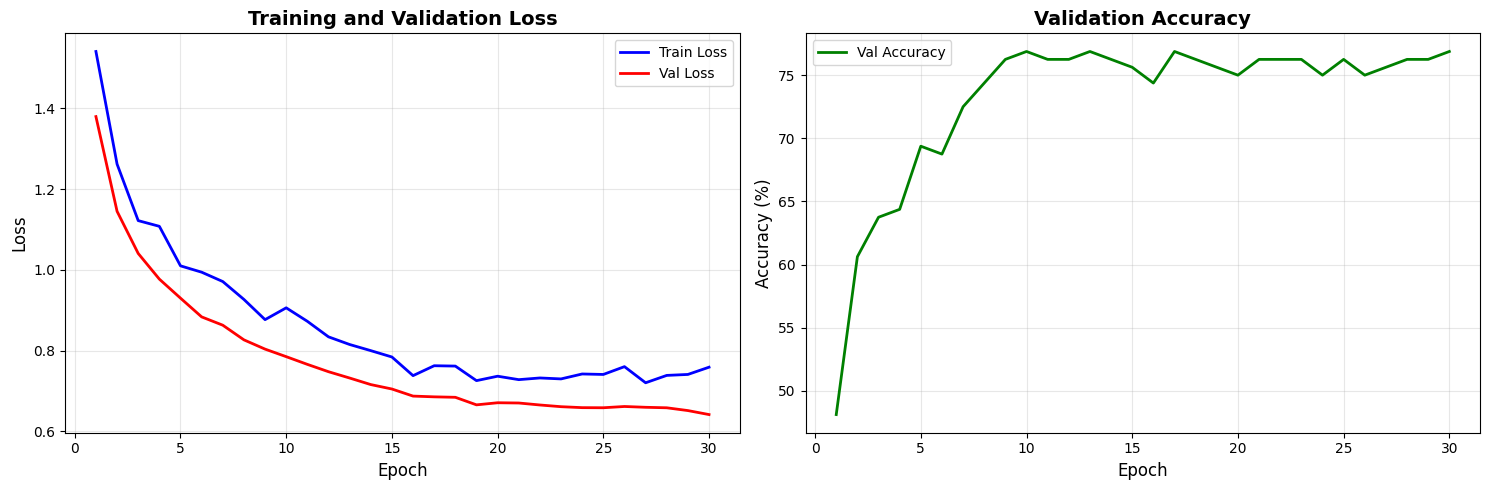

STEP 3: EVALUATING MODEL



Testing: 100%|██████████| 8/8 [00:00<00:00, 58.44it/s]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

Downward Dog       0.95      0.99      0.97        97
     Goddess       0.60      0.61      0.61        80
       Plank       0.85      0.98      0.91       115
        Tree       0.87      0.96      0.91        69
   Warrior 2       0.73      0.53      0.62       109

    accuracy                           0.81       470
   macro avg       0.80      0.81      0.80       470
weighted avg       0.80      0.81      0.80       470


Confusion Matrix:
[[ 96   0   1   0   0]
 [  0  49   6   4  21]
 [  2   0 113   0   0]
 [  1   2   0  66   0]
 [  2  30  13   6  58]]



✅ Saved confusion matrix to 'confusion_matrix.png'


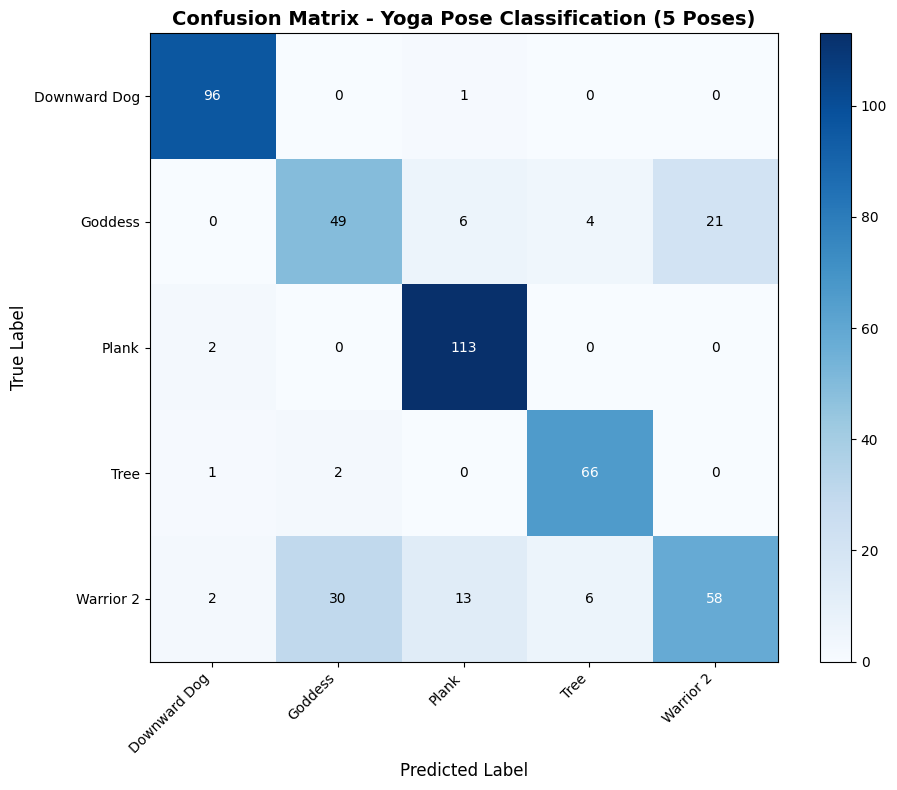


COMPLETE!
Best Validation Accuracy: 76.88%



In [24]:
def main():
    print("\n" + "=" * 60)
    print("OPTIMIZED YOGA POSE CLASSIFICATION")
    print("=" * 60 + "\n")

    DATASET_DIR = '/content/drive/MyDrive/archive/DATASET'
    BATCH_SIZE = 64  # Increased since no image processing
    NUM_EPOCHS = 30
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    CACHE_FILE = 'yoga_features_cache.pkl'

    print(f"Device: {DEVICE}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Epochs: {NUM_EPOCHS}\n")

    # Step 1: Pre-extract features (runs once, then cached)
    features_dict = preprocess_dataset(DATASET_DIR, CACHE_FILE)

    # Step 2: Create fast datasets
    train_dataset = PrecomputedFeaturesDataset(features_dict['TRAIN'])
    val_dataset = PrecomputedFeaturesDataset(features_dict['VAL'])
    test_dataset = PrecomputedFeaturesDataset(features_dict['TEST'])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                           shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=2, pin_memory=True)

    print(f"\nDataset sizes:")
    print(f"  Train: {len(train_dataset)}")
    print(f"  Val: {len(val_dataset)}")
    print(f"  Test: {len(test_dataset)}\n")

    # Step 3: Train model
    model = FeatureClassifier(input_dim=10, num_classes=5)
    trainer = Trainer(model, train_loader, val_loader, DEVICE)
    best_acc = trainer.train(num_epochs=NUM_EPOCHS)

    # Step 4: Evaluate
    plot_training_history(trainer)

    checkpoint = torch.load('checkpoints/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    class_names = ['Downward Dog', 'Goddess', 'Plank', 'Tree', 'Warrior 2']
    evaluate_model(model, test_loader, DEVICE, class_names)

    print("\n" + "=" * 60)
    print("COMPLETE!")
    print("=" * 60)
    print(f"Best Validation Accuracy: {best_acc:.2f}%\n")
if __name__ == '__main__':
    main()

In [25]:
def predict_single_image(image_path, model_path='checkpoints/best_model.pth'):

    print("\n" + "=" * 60)
    print("PREDICTING YOGA POSE")
    print("=" * 60 + "\n")

    # Load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = FeatureClassifier(input_dim=10, num_classes=5)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Class names
    class_names = ['Downward Dog', 'Goddess', 'Plank', 'Tree', 'Warrior 2']

    # Initialize pose landmarker
    model_path = download_pose_model()
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        output_segmentation_masks=False
    )
    pose_landmarker = vision.PoseLandmarker.create_from_options(options)

    # Load and process image
    print(f"Loading image: {image_path}")
    image = Image.open(image_path).convert('RGB')

    # Extract features
    print("Extracting pose features...")
    features = extract_pose_features(image, pose_landmarker)
    pose_landmarker.close()

    if np.all(features == 0):
        print("⚠️  No pose detected in image!")
        return None

    # Predict
    features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100

    # Display results
    print("\n" + "=" * 60)
    print("PREDICTION RESULTS")
    print("=" * 60)
    print(f"\n🧘 Predicted Pose: {predicted_class}")
    print(f"📊 Confidence: {confidence_score:.2f}%\n")


In [31]:
predict_single_image(image_path = "/content/warrior2.png")


PREDICTING YOGA POSE

Loading image: /content/downwarddog1.png
Extracting pose features...

PREDICTION RESULTS

🧘 Predicted Pose: Warrior 2
📊 Confidence: 63.77%

